In [2]:
#!/usr/bin/env python3

import sys
import pandas as pd
import datetime
import requests
import numpy as np
from pandas import ExcelWriter
import os
import glob
import pytz
from dateutil.tz import gettz
import timeit

# from datetime import datetime
from datetime import timedelta
import time
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)

In [3]:
def read_data(devid, acc_token, address, start_time, end_time, descriptors):


    r2 = requests.get(
        url=address + "/api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=" + descriptors + "&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    if r2:
        df = pd.DataFrame([])

        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            df = pd.concat([df, df1], axis=1)

        
        if df.empty == False:

            df.reset_index(drop=False, inplace=True)
            df = df.sort_values(by=['ts'])
            df.reset_index(drop=True, inplace=True)
            df.set_index('ts', inplace=True, drop=True)
            for col in df.columns:
                df[col] = df[col].astype('float')

            df = df.groupby(df.index).max()
            
        else:
            df = pd.DataFrame([])
    else:
        df = pd.DataFrame([])
#         print('Empty json!')
    return df

def request_data(start_time,end_time,devid,acc_token,address,descriptors):
    df = pd.DataFrame([])
    svec = np.arange(int(start_time[0]),int(end_time[0]),3600000)
    hour = 1
    for st in svec:
    #     print(hour)
        hour = hour+1
        en = st+3600000-1

        if int(end_time[0])-en<=0: en = int(end_time[0])
    #         print('start and end of iteration:',st,en)

        tmp = read_data(devid, acc_token, address, str(st), str(en), descriptors)
        if not tmp.empty:
            df = pd.concat([df,tmp])


    df['ts'] = pd.to_datetime(df.index,utc=True, unit='ms')
    df['ts'] = df['ts'].dt.tz_convert('Europe/Athens')

    df.set_index('ts',inplace=True, drop=True)
    return df


def run_models(df,maphase,phase,mdlphase,mdlpath):
    step=10
    events = []
    nums = []
    state = []
    ev_ts = []
    dpwr = [] # delta active power --> |previous power - current power|
    conflicts = {}
    ln=0
    i=0
    
    while ln<=df.shape[0]-141:
        dt1 = df.index[ln]
        dt2 = df.index[ln]+datetime.timedelta(milliseconds=20*140)
        ln = ln+df[dt1:dt2].shape[0]

        slot = df[maphase[phase]].copy()
        slot = slot[dt1:dt2]
        if slot.shape[0]>100:
            tsm = slot.index[-1]
            slot.columns = ['pwr','rpwr']
            slot.reset_index(inplace=True, drop=True)
            steady = slot.iloc[:10].copy()
            change = slot.iloc[-100:].copy()
            change.reset_index(inplace=True, drop=True)

            # discover if appliance has been added or removed
            if (np.mean(change['pwr'].iloc[-20:-10])-np.mean(steady['pwr']))>0:
                st = 1
            else:
                st = 0

            # subtract active & reactive power of steady state
            change['pwr'] = np.abs(change['pwr']-np.mean(steady['pwr']))
            change['rpwr'] = np.abs(change['rpwr']-np.mean(steady['rpwr']))
            change.dropna(inplace=True)

            cols = ['pwr','rpwr']

            df_pr = pd.DataFrame([])
            for col in cols:
                df_pr[col+'_mean'] = change[col].groupby(np.arange(len(change))//step).mean()
                df_pr[col+'_std'] = change[col].groupby(np.arange(len(change))//step).std()
                df_pr[col+'_min'] = change[col].groupby(np.arange(len(change))//step).min()
                df_pr[col+'_max'] = change[col].groupby(np.arange(len(change))//step).max()
    #             df_pr[col+'_skew'] = change[col].groupby(np.arange(len(change))//step).skew()
    #             df_pr[col+'_kurt'] = change[col].groupby(np.arange(len(change))//step).apply(pd.Series.kurt)
            df_pr.dropna(inplace=True)

            assigned = False

            # run all models for this phase
            for j in range(0,len(mdlphase[phase])):
                filename = mdlpath+str(mdlphase[phase][j])+'.sav'
                mdl = pickle.load(open(filename, 'rb'))
                y_pred = mdl.predict(df_pr)
                if np.sum(y_pred)>=0.7*len(y_pred):

                    if assigned==False: 
                        dpwr.append(np.abs(np.mean(change['pwr'].iloc[-20:-10])-np.mean(steady['pwr'])))
                        nums.append(np.sum(y_pred))
                        events.append(mdlphase[phase][j])
                        ev_ts.append(tsm)
                        state.append(st)
                        assigned=True

                        i=i+1
                    else:
                        if np.sum(y_pred)>=nums[i-1]:
                            conflicts[ev_ts[i-1]]= [mdlphase[phase][j]]
    #end of while
    
    ev = confl_postproc(events,state,ev_ts,conflicts,dpwr)
    return ev


def events_clearing(ev,events,mappings):
    # convert categorical variables to numeric

#     ev['appl'] = ev['appl'].astype('category')
#     globals()['d%s' % phase] = dict(enumerate(ev['appl'].cat.categories))
#     ev['appl'] = ev['appl'].cat.codes
    ev.replace({'appl': { v : k for k, v in mappings.items() }},inplace=True)
    
    ev = ev.resample('1S').max()
    globals()['ev%s' % phase] = ev.copy()
    
    # append dataframes to dictionaries
    events.append(globals()['ev%s' % phase])
#     mappings.append(globals()['d%s' % phase])
    
    return events    



def confl_postproc(events,state,ev_ts,conflicts,dpwr):
    
    ev = pd.DataFrame([])
    ev['appl'] = events
    ev['state'] = state
    ev['ts'] = ev_ts
    ev['dpwr'] = dpwr
    ev=ev.dropna()
    ev.set_index('ts',inplace=True)

    if len(conflicts)>0:
        confl = pd.DataFrame(conflicts).T
        confl.columns = ['conflict']
        ev = pd.concat([ev,confl],axis=1)

        for i in range(5,ev.shape[0]-5):
            if pd.isna(ev['conflict'].iloc[i])==False:
        #         print(ev['conflict'].iloc[i],ev['appl'].iloc[i],ev['appl'].iloc[i-1])
                if ev['conflict'].iloc[i]==ev['appl'].iloc[i-5:i+5].value_counts()[:1].index.tolist()[0]:
                    ev['appl'].iloc[i] = ev['conflict'].iloc[i]
    else:
        ev['conflict'] = np.nan
#         ev.drop('conflict',axis=1,inplace=True)

    return ev

 
# heatpump post process
def hp_postproc(events,mappings):
    phases = ['A','B','C']

    # encode conflicts column with corresponding dictionary values
    for i in range(0,3):
        if events[i]['conflict'].notnull().sum()>0:
            events[i].replace({'conflict': { v : k for k, v in mappings[i].items() }},inplace=True)

    # indexes of rows where heatpump was found at each phase
    indA= events[0].loc[events[0]['appl'] == max(mappings[0], key=lambda k: mappings[0][k] == 'heatpumpA')].index
    indB= events[1].loc[events[1]['appl'] == max(mappings[1], key=lambda k: mappings[1][k] == 'heatpumpB')].index
    indC= events[2].loc[events[2]['appl'] == max(mappings[2], key=lambda k: mappings[2][k] == 'heatpumpC')].index

    # if there is an intersection between at least two phases' indexes, assign appliance=heatpump on the ohter phase
    events[0].loc[indB.intersection(indC),'appl']=max(mappings[0], key=lambda k: mappings[0][k] == 'heatpumpA')
    events[1].loc[indA.intersection(indC),'appl']=max(mappings[1], key=lambda k: mappings[1][k] == 'heatpumpB')
    events[2].loc[indA.intersection(indB),'appl']=max(mappings[2], key=lambda k: mappings[2][k] == 'heatpumpC')

    # if heatpump is found at only one phase, this is a false positive. Replace with conflict or leave empty
    events[0].loc[indA.difference(indB),'appl'] = events[0].loc[indA.difference(indB),'conflict']
    events[1].loc[indB.difference(indC),'appl'] = events[1].loc[indB.difference(indC),'conflict']
    events[2].loc[indC.difference(indA),'appl'] = events[2].loc[indC.difference(indA),'conflict']
    
    return events


def postproc(events):
    # drop events corresponding to only one appearance of an appliance 
    for i in range(0,len(events)):
        singlapp = events[i]['appl'].value_counts()
        if singlapp[singlapp==1].shape[0]>0:
            events[i] = events[i][events[i]['appl'] != singlapp[singlapp==1].index.values[0]]
            print(mappings[i][singlapp[singlapp==1].index.values[0]])
    return events


In [126]:
# set phase and appliances' mappings to dictionaries
mdlpath = '../../Desktop/windowsshare/stelios_data/models/'
maphase = {'A':['pwrA','rpwrA'],'B':['pwrB','rpwrB'],'C':['pwrC','rpwrC']}
mdlphase = {'A':['entilator','fridge','heatpumpA','oven','stove','vacuum','wash'],'B':['coffee','dish','freezer','heatpumpB'],'C':['iron','ironpress','heatpumpC','PC']}

# devmap = {'mdl0':'dishwasher','mdl1':'entilator','mdl2':'freezer','mdl3':'fridge','mdl4':'heatpumpA','mdl5':'heatpumpB','mdl6':'heatpumpC','mdl7':'iron','mdl8':'ironpress','mdl9':'Oven','mdl10':'stove','mdl11':'vacuum','mdl12':'washingMashine'}

# Download events for phase
devid = '71749ca0-9a6a-11ea-8d54-4d0d5d00237b'

# start_time = [1591909200000] #12/6/2020
# end_time = [1591995600000]
start_time = [1596661200000] # 6/8/2020
end_time = [1596747600000]

address = "http://52.77.235.183:8080"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'tenant@thingsboard.org', 'password': 'tenant'}).json()

acc_token = 'Bearer' + ' ' + r['token']
##########################
# timediff = int(end_time[0])-int(start_time[0])



In [127]:
events = []
mappings=[]
for key,value in mdlphase.items():
    # create list  of dictionaries for each phase's appliances with integer keys
    mappings.append(dict(zip(range(len(value)),value)))

i=0
for phase in ['A','B','C']:
    print('phase ',phase)
    descriptors = maphase[phase][0]+','+maphase[phase][1]

    df = request_data(start_time,end_time,devid,acc_token,address,descriptors)
    
    ev = run_models(df,maphase,phase,mdlphase,mdlpath)
    
    events = events_clearing(ev,events,mappings[i])
    
    i = i+1

# ensure heatpump appears to function across all 3 phases, otherwise it's a false positive
events = hp_postproc(events,mappings)
# remove events of appliances that appear only once
events = postproc(events)

phase  A


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


phase  B
phase  C
vacuum
coffee


In [128]:
for i in range(0,3):
    a = events[i]['appl'].unique()
    a = a[a==a]
    print(a)
    for j in a:
        events[i].loc[events[i]['appl']==j] = events[i].loc[events[i]['appl']==j][events[i].loc[events[i]['appl']==j]['state']!= events[i].loc[events[i]['appl']==j]['state'].shift()]
        
        tmp = events[i].loc[events[i]['appl']==j].copy()
        
#         # if 1st event is 0 then drop
#         if tmp['state'].iloc[0]<1:
#             tmp = tmp.iloc[1:]
#         # if last event is 1 then drop
#         if tmp['state'].iloc[-1]>0:
#             tmp = tmp.iloc[:-1]
        
        # calculate time difference between on/off
        tmp = tmp.loc[tmp['state']>=0]
        tmp['ts'] =  tmp.index
        tmp['dif'] = tmp['ts'].values-tmp['ts'].shift().values
        tmp['dif'] = tmp['dif'].dt.seconds.fillna(0)
        
        # drop on/offs with duration less than 1 min
#         tmp = tmp[(tmp['dif']>60) | (tmp['dif'].shift(-1)>60) | (tmp['dif']==0)]
        
        # keep only first instance of each state
        tmp.loc[(tmp['state']==0.0) & (tmp['state'].shift()==1.0),'onoff'] = 1
        tmp.loc[(tmp['state']==1.0) & (tmp['state'].shift()==0.0) & (tmp['onoff'].shift()==1),'onoff'] = 1
        tmp['onoff'].iloc[0] = 1
#         tmp = tmp.loc[(tmp['state']==0.0) & (tmp['state'].shift()==1.0)]
        
        #calculate time difference again
        tmp['dif'] = tmp['ts'].values-tmp['ts'].shift().values
        tmp['dif'] = tmp['dif'].dt.seconds.fillna(0)
        tmp.drop('ts',axis=1, inplace=True)  
        
#         tmp = tmp.loc[tmp['onoff']==1]
        
        events[i] = events[i].loc[events[i]['appl']!=j]
        events[i] = pd.concat([events[i],tmp[['appl','state','dpwr','conflict','dif','onoff']]])
        events[i].sort_index(inplace=True)

[6. 1. 4. 3.]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[1.]
[3. 1.]


In [129]:
# download full house data
devid = '4353f360-98d6-11ea-8d54-4d0d5d00237b'
descriptors = 'pwrA,cnrgA,pwrB,cnrgB,pwrC,cnrgC'




address = "http://52.77.235.183:8080"

r = requests.post(address + "/api/auth/login",
                  json={'username': 'tenant@thingsboard.org', 'password': 'tenant'}).json()

# acc_token is the token to be used in the next request
acc_token = 'Bearer' + ' ' + r['token']


timediff = int(end_time[0])-int(start_time[0])

# if difference between end and start time is greater than 15 minutes, split data 

summary = pd.DataFrame([])
svec = np.arange(int(start_time[0]),int(end_time[0]),2500000)
hour = 1
for st in svec:
    print(hour)
    hour = hour+1
    en = st+2500000-1

    if int(end_time[0])-en<=0: en = int(end_time[0])
#         print('start and end of iteration:',st,en)

    tmp = read_data(devid, acc_token, address, str(st), str(en), descriptors)
    if not tmp.empty:
        summary = pd.concat([summary,tmp])




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [130]:
# summary = summary[['pwrA','cnrgA']]
summary['ts'] = pd.to_datetime(summary.index,utc=True, unit='ms')
summary['ts'] = summary['ts'].dt.tz_convert('Europe/Athens')

summary.set_index('ts',inplace=True, drop=True)
# summary = summary.resample('1S').mean()

summary.head()

,pwrA,cnrgA,pwrB,cnrgB,pwrC,cnrgC
ts,,,,,,
2020-08-06 00:00:00.008000+03:00,387.2772,968786.0,65.9139,439523.0,29.2088,323933.0
2020-08-06 00:00:00.028000+03:00,383.2319,968786.0,65.9139,439523.0,29.2749,323933.0
2020-08-06 00:00:00.048000+03:00,379.5168,968786.0,65.9799,439523.0,29.2914,323933.0
2020-08-06 00:00:00.068000+03:00,376.4127,968786.0,66.0295,439523.0,29.1758,323933.0
2020-08-06 00:00:00.088000+03:00,374.0185,968786.0,66.0625,439523.0,29.0602,323933.0


In [101]:
# appl=0.0

# tmp = summary.copy()
# tmp = tmp.resample('1S').mean()
# tmp = pd.concat([tmp,events[0]],axis=1)
# # tmp = tmp[['cnrgA','state','pwrA']]
# tmp = tmp[(tmp.index>=ndf.index[0]) & (tmp.index<=ndf.index[-1])]
# tmp = tmp[pd.notnull(tmp['appl'])]

# tmp['ts'] = tmp.index
# # tmp['dif'] = tmp['ts'].values-tmp['ts'].shift().values
# # if within this time slot more than 1 appliances are present
# if len(tmp['appl'].unique())>1:
#     alt_app = tmp['appl'].unique()[tmp['appl'].unique()!=appl][0]
#     foreign = tmp[tmp['appl']==alt_app]
    
#     if foreign.shape[0]==1:
#         if foreign['state'].values==0:
#             print('Appliance is off')
#             dur = (foreign['ts'] - tmp['ts'].iloc[0]).dt.total_seconds()
#             print(dur)
#         else:
#             print('Appliance is on')
#     else:
#         print('Appliance was turned on and off again')

In [59]:
# For each pair of on/off create a row on a new df
# dE, previous or next 10samples' active power, and duration in seconds are the columns

ndf = summary.copy()
ndf = ndf.resample('1S').mean()
ndf = ndf[['cnrgA','pwrA']]
ndf = pd.concat([ndf,events[0]],axis=1)

ndf['pr_pwr'] = (ndf['pwrA'].shift(3)+ndf['pwrA'].shift(4)+ndf['pwrA'].shift(5)+ndf['pwrA'].shift(6))/4
# ndf = ndf.loc[ndf['onoff']>=0]

ndf

,cnrgA,pwrA,appl,conflict,dif,dpwr,onoff,state,pr_pwr
2020-08-08 00:00:00+03:00,994052.46,299.208522,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08 00:00:01+03:00,994053.00,300.085282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08 00:00:02+03:00,994053.00,297.729752,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08 00:00:03+03:00,994053.00,298.172592,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-08 00:00:04+03:00,994053.00,297.945066,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020-08-08 23:59:55+03:00,1001112.00,312.471880,NaN,NaN,NaN,NaN,NaN,NaN,312.882786
2020-08-08 23:59:56+03:00,1001112.00,311.936582,NaN,NaN,NaN,NaN,NaN,NaN,312.746650
2020-08-08 23:59:57+03:00,1001112.00,312.052820,NaN,NaN,NaN,NaN,NaN,NaN,312.503020
2020-08-08 23:59:58+03:00,1001112.00,311.839824,NaN,NaN,NaN,NaN,NaN,NaN,312.391319


In [146]:
# fridge
ndf = summary.copy()
ndf = ndf.resample('1S').mean()
ndf = ndf[['cnrgA','pwrA']]
ndf = pd.concat([ndf,events[0]],axis=1)

ndf['pr_pwr'] = (ndf['pwrA'].shift(3)+ndf['pwrA'].shift(4)+ndf['pwrA'].shift(5)+ndf['pwrA'].shift(6))/4

tmp = ndf.loc[ndf['appl']==1]

# tmp = tmp.iloc[:-1]

# check if fridge is already ON when day begins
if tmp['state'].iloc[0]==0.0:
    tmp['dif'].iloc[0] = (tmp.index[0].hour*3600)+(tmp.index[0].minute*60)+tmp.index[0].second

    # check if fridge is left at ON state as the day ends
if tmp['state'].iloc[-1]==1.0:
    tmp['dif'].iloc[-1] = (23-tmp.index[-1].hour)*3600+(60-tmp.index[0].minute)*60+(60-tmp.index[0].second)
    
    

    
tmp = tmp[tmp['state']==0]
tmp['dE'] = (tmp['dif']*avgpr.loc[avgpr['app']=='fridge','pwr'].values[0])/3600
tmp['dpwr'] = tmp['pr_pwr']-tmp['pwrA']

# tmp['dE'] = (tmp['pr_pwr']-tmp['pwrA'])*tmp['dif']/3600


tmp['dE'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


2744.222707296917

In [148]:
# dishwasher

ndf = summary.copy()
ndf = ndf.resample('1S').mean()
ndf = ndf[['cnrgB','pwrB']]
ndf = pd.concat([ndf,events[1]],axis=1)

ndf['pr_pwr'] = (ndf['pwrB'].shift(3)+ndf['pwrB'].shift(4)+ndf['pwrB'].shift(5)+ndf['pwrB'].shift(6))/4

tmp = ndf.loc[ndf['appl']==1]

 
# tmp = tmp[tmp['state']==0]
# # tmp['dE'] = (tmp['dif']*avgpr.loc[avgpr['app']=='dish','pwr'].values[0])/3600
# tmp['dpwr'] = tmp['pr_pwr']-tmp['pwrB']

# tmp['dE'] = (tmp['pr_pwr']-tmp['pwrB'])*tmp['dif']/3600
# print('dE estimation is: ',tmp['dE'].sum())


totaldif = (tmp.index.to_series()[-1]-tmp.index.to_series()[0]).total_seconds()
dE = (tmp['cnrgB'].iloc[-1] - tmp['cnrgB'].iloc[0]) - (totaldif*tmp['pr_pwr'].iloc[0])/3600
# gd = 1287
# print('dE accuracy is:',(1-np.abs(gd-dE)/gd)*100)
dE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.


1157.9015794986112

In [107]:
# Load average power of each appliance
avgpr = pd.read_csv('avg_pwr.csv')
avgpr

,app,pwr
0,coffee,1278.149178
1,dish,1013.021317
2,entilator,54.203532
3,freezer,103.565513
4,fridge,145.695898
5,heatpumpA,696.073729
6,heatpumpB,436.582591
7,heatpumpC,678.175755
8,iron,1117.907195
9,ironpress,1320.883652


In [100]:
# # ndf['pr_pwr'] =ndf['pwrA'].rolling(2).mean() - ndf['pwrA'].rolling(30).mean()
# # ndf['dE'] = ndf['cnrgA']-ndf['cnrgA'].shift(15)
# ndf['pr_pwr'] = (ndf['pwrA'].shift(3)+ndf['pwrA'].shift(4)+ndf['pwrA'].shift(5)+ndf['pwrA'].shift(6))/4
# ndf = ndf.loc[ndf['state']>=0]
# ndf['ts'] = ndf.index
# ndf['dif'] = ndf['ts'].values-ndf['ts'].shift().values
# # ndf['dif'] = ndf[ndf['state'].isna()==False,'ts'].values-ndf[ndf['state'].isna()==False,'ts'].shift().values
# ndf['dif'] = ndf['dif'].dt.seconds.fillna(0)
# ndf.drop('ts',axis=1, inplace=True)
# ndf.head()

In [11]:
ndf['pr_pwr'] = ndf['pr_pwr'].shift()
ndf['pwrA'] = ndf['pwrA'].shift()

ndf.loc[(ndf['state']==0.0) & (ndf['state'].shift()==1.0),'onoff'] = 1
# ndf['dE'] = ndf['cnrgA'] - ndf['cnrgA'].shift() - ((ndf['pr_pwr'].shift()*ndf['dif'])/3600)
ndf['dE'] = (ndf['pwrA']*ndf['dif'] - ndf['pr_pwr']*ndf['dif'])/3600
ndf = ndf.loc[ndf['state']==0.0]
ndf

,cnrgA,state,pwrA,pr_pwr,dif,onoff,dE
2020-06-12 00:12:00+03:00,362836.00,0.0,444.599218,373.844220,10.0,1.0,0.196542
2020-06-12 00:12:12+03:00,362838.00,0.0,482.412530,373.218516,4.0,1.0,0.121327
2020-06-12 00:12:28+03:00,362840.00,0.0,483.189562,483.249744,7.0,1.0,-0.000117
2020-06-12 00:12:47+03:00,362842.00,0.0,496.795028,372.161612,10.0,1.0,0.346204
2020-06-12 00:13:00+03:00,362844.00,0.0,499.083335,372.588268,5.0,1.0,0.175688
2020-06-12 00:13:34+03:00,362848.00,0.0,525.662758,366.340729,10.0,1.0,0.442561
2020-06-12 00:13:45+03:00,362849.00,0.0,531.327524,366.096690,3.0,1.0,0.137692
2020-06-12 00:13:59+03:00,362851.44,0.0,533.039764,527.251985,11.0,1.0,0.017685
2020-06-12 00:14:14+03:00,362853.00,0.0,554.796962,365.994238,3.0,1.0,0.157336
2020-06-12 00:14:31+03:00,362855.46,0.0,545.906848,365.504751,3.0,1.0,0.150335


In [109]:
mappings[1].items() 

dict_items([(0, 'coffee'), (1, 'dish'), (2, 'freezer'), (3, 'heatpumpB')])

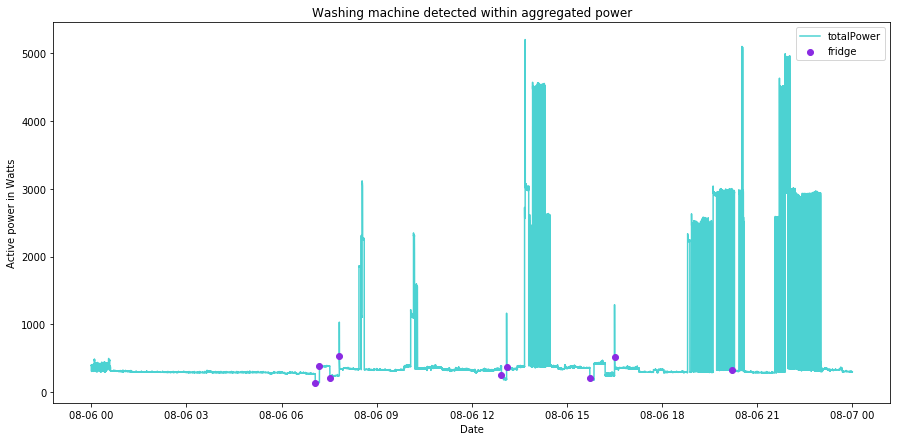

In [132]:
phases = ['A','B','C']
for j in range(0,1):
    ndf = summary.copy()
    ndf = ndf.resample('1S').mean()
    ndf = pd.concat([ndf,events[j]],axis=1)

    pwr = maphase[phases[j]][0]
    fig = plt.figure(figsize=[15,7])
    plt.plot(ndf.index,ndf[pwr],'c',alpha=0.7)#,df2.index,df2['rpwrB'])
    colors = ['blueviolet','green','red','orchid','orange','aqua','deepskyblue']

    values=[]
    items = mappings[j].items() 
    for item in items: 
        values.append(item[1]) 


    for i in range(0,1):
        cl = ndf['appl']==1
        plt.scatter(ndf.index[cl], ndf[pwr][cl], color=colors[i],zorder=10)
    plt.xlabel('Date')
    plt.ylabel('Active power in Watts')
    plt.legend(['totalPower']+['fridge'])
    plt.title('Washing machine detected within aggregated power')
    



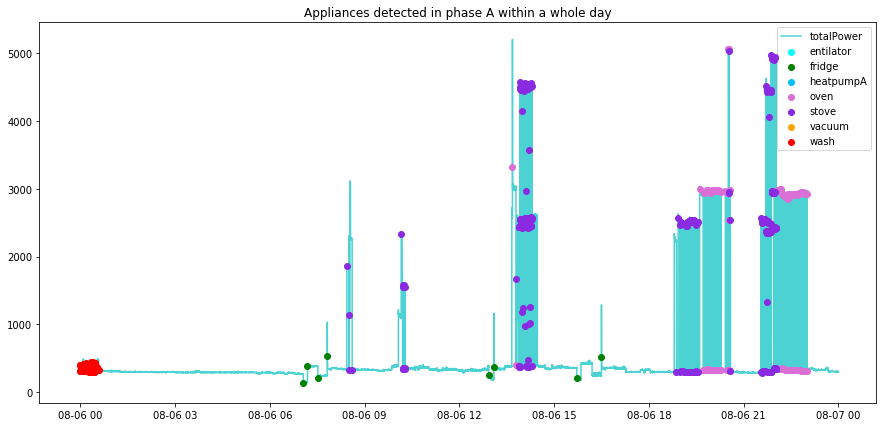

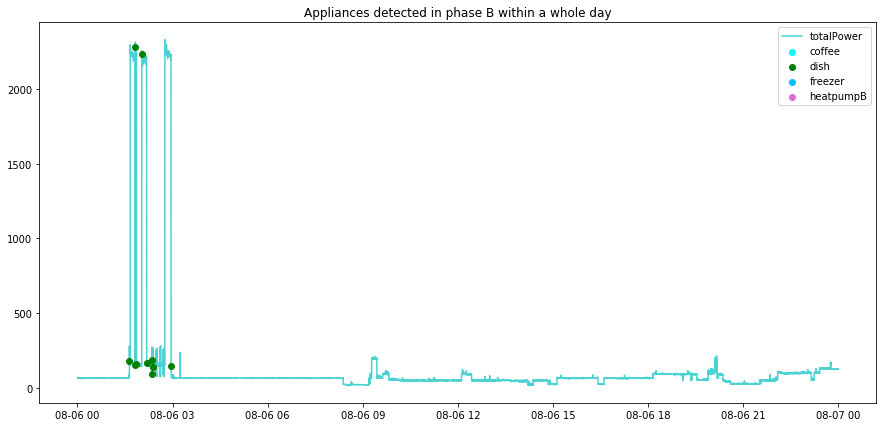

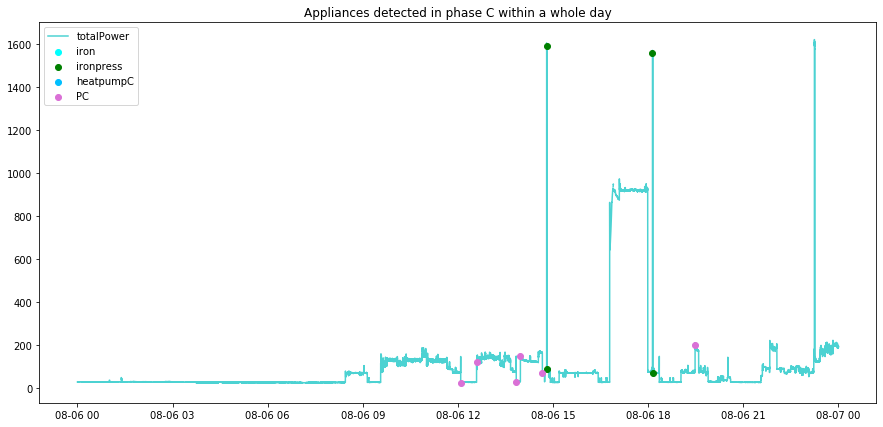

In [149]:
phases = ['A','B','C']
for j in range(0,3):
    ndf = summary.copy()
    ndf = ndf.resample('1S').mean()
    ndf = pd.concat([ndf,events[j]],axis=1)

    pwr = maphase[phases[j]][0]
    fig = plt.figure(figsize=[15,7])
    plt.plot(ndf.index,ndf[pwr],'c',alpha=0.7)#,df2.index,df2['rpwrB'])
    colors = ['aqua','green','deepskyblue','orchid','blueviolet','orange','red']

    values=[]
    items = mappings[j].items() 
    for item in items: 
        values.append(item[1]) 


    for i in range(0,len(mappings[j])):
        cl = ndf['appl']==i
        plt.scatter(ndf.index[cl], ndf[pwr][cl], color=colors[i],zorder=10)

    plt.legend(['totalPower']+values)
    plt.title('Appliances detected in phase '+phases[j]+' within a whole day')